In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
%matplotlib inline

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
from textrec.paths import paths

In [6]:
dataset = pd.read_csv(paths.data / 'num_details_training_set.csv')

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


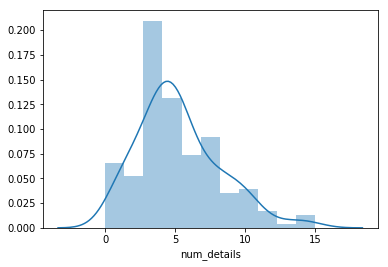

In [7]:
sns.distplot(dataset.num_details)

# Preprocessing

Strip off punctuation; it just throws off token counts and probs. (We get a few percent boost in r^2 because of this.)

In [8]:
def strip_uninformative(text):
    text = text.strip()
    for beginning in ['there is', 'there are', 'a view of', 'a photo of', 'a photo shows']:
        beginning = beginning + ' '
        if text.startswith(beginning):
            text = text[len(beginning):]
            return strip_uninformative(text)
    return text

In [9]:
strip_uninformative('there is a view of a red thing there')

'a red thing there'

In [10]:
dataset['text'] = dataset.text.str.strip().str.rstrip('.')
dataset['text'] = dataset.text.apply(strip_uninformative)

# Word Frequencies

In [11]:
import wordfreq

dataset['num_words'] = [
    len(wordfreq.tokenize(text, 'en'))
    for text in dataset.text]

dataset['min_freq'] = [
    np.min([wordfreq.zipf_frequency(tok, 'en') for tok in wordfreq.tokenize(text, 'en')])
    for text in dataset.text]

dataset['mean_freq'] = [
    np.mean([wordfreq.zipf_frequency(tok, 'en') for tok in wordfreq.tokenize(text, 'en')])
    for text in dataset.text]

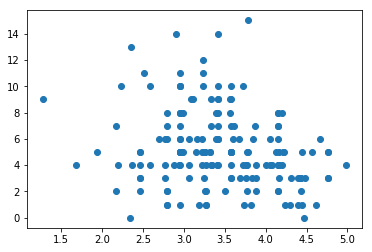

In [12]:
plt.scatter(dataset.min_freq, dataset.num_details)

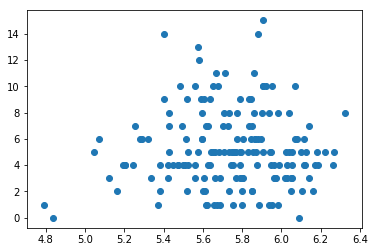

In [13]:
plt.scatter(dataset.mean_freq, dataset.num_details)

# Perplexity

The perplexity of a language model is a rough proxy for the amout of information that a text contains. The more details included, the more uncertainty the LM has; and redundant text doesn't get counted. It's not quite right for a few reasons:

- Typos, grammar errors, etc. also increase perplexity
- Unusual wording of the same concepts increases perplexity
- Using a word that's _more_ common than expected increases perplexity.

But we'll try it anyway.

In [14]:
from textrec import automated_analyses
from textrec import onmt_model_2

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.
Loading SpaCy...done


In [15]:
automated_analyses.eval_logprobs_unconditional(dataset.text.iloc[0])

3.3479643

In [16]:
example_text = dataset.text.iloc[0]
example_text

'families stand around by the water flying kites on a sunny day'

In [17]:
tokens = onmt_model_2.tokenize(example_text)
logprobs = onmt_model_2.models['coco_lm'].eval_logprobs('.', tokens, use_eos=True)
logprobs

array([1.0859766e+01, 4.1381788e+00, 2.3187706e+00, 7.0211720e+00,
       1.5096430e+00, 2.1149969e+00, 5.2354274e+00, 3.4142053e-01,
       5.1307883e+00, 1.5549884e+00, 1.9299134e+00, 3.4333759e-03,
       1.3650393e+00], dtype=float32)

In [18]:
dataset['num_tokens'] = dataset.text.apply(lambda text: len(onmt_model_2.tokenize(text)))
dataset['mean_logprob_uncond'] = dataset.text.apply(lambda text: automated_analyses.eval_logprobs_unconditional(text))
dataset['total_logprob_uncond'] = dataset.mean_logprob_uncond * (dataset.num_tokens + 1)

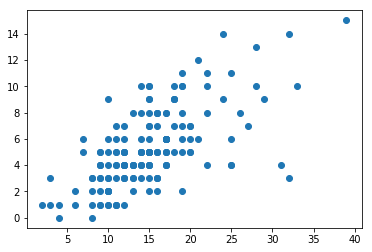

In [19]:
plt.scatter(dataset.num_tokens, dataset.num_details)

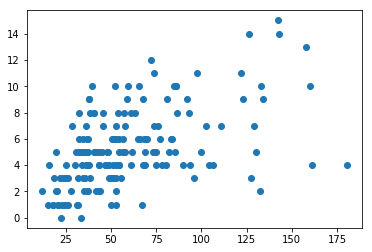

In [20]:
plt.scatter(dataset.total_logprob_uncond, dataset.num_details)

# Models

In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 9 columns):
image_id                168 non-null int64
text                    168 non-null object
num_details             168 non-null int64
num_words               168 non-null int64
min_freq                168 non-null float64
mean_freq               168 non-null float64
num_tokens              168 non-null int64
mean_logprob_uncond     168 non-null float64
total_logprob_uncond    168 non-null float64
dtypes: float64(4), int64(4), object(1)
memory usage: 11.9+ KB


In [22]:
dataset[dataset.num_words != dataset.num_tokens][['text', 'num_words', 'num_tokens']]

,text,num_words,num_tokens
14,a man in a red shirt with two children are on ...,26,25
19,a man in a red shirt is helping his children f...,16,15
22,the image shows a railroad track with a train ...,30,31
35,"a train passing a few small buildings, perhaps...",10,11
41,a landscape of a train stop with an old-lookin...,21,20
43,a black-and-white picture of a young couple cu...,24,22
45,a woman is standing next to a couple in front ...,24,25
56,"a husband, bride and female all stand in front...",18,19
80,a man-woman gracefully riding a wave using a s...,10,9
81,a surfer is riding a wave the water looks so r...,15,16


In [23]:
dataset.mean_freq.describe()

count    168.000000
mean       5.738019
std        0.283893
min        4.790000
25%        5.579911
50%        5.764444
75%        5.942990
max        6.323333
Name: mean_freq, dtype: float64

Let's try including the interaction of mean_freq and tokens. That's sorta like the total word frequency.. if we invert frequency to make `rarity`, then it's total rarity, or something proportional to unigram perplexity.

In [24]:
dataset['mean_rarity'] = (7 - dataset.mean_freq) / 7
dataset['max_rarity'] = (7 - dataset.min_freq) / 7
dataset['total_rarity'] = dataset['mean_rarity'] * dataset['num_words']

In [25]:
formulas = '''
C(image_id) + min_freq + mean_freq
C(image_id) + total_rarity
C(image_id) + num_tokens + total_rarity
C(image_id) + num_words + total_rarity
C(image_id) + num_tokens + total_rarity + total_logprob_uncond + mean_logprob_uncond
C(image_id) + num_tokens + mean_rarity + max_rarity + total_rarity + total_logprob_uncond + mean_logprob_uncond + max_rarity*num_tokens
C(image_id) + num_tokens + mean_rarity + max_rarity + total_rarity + max_rarity*num_tokens
'''.split('\n')

models = {}
for formula in formulas:
    formula = formula.strip()
    if not formula:
        continue
    formula_full = 'num_details ~ ' + formula
    models[formula] = model = smf.ols(formula_full, dataset).fit()
    display(HTML(f'<h1>r^2={model.rsquared:.3f}: {formula}</h1>'))
    display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     10.98
Date:                Thu, 11 Oct 2018   Prob (F-statistic):           3.40e-13
Time:                        10:37:05   Log-Likelihood:                -378.74
No. Observations:                 168   AIC:                             777.5
Df Residuals:                     158   BIC:                             808.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.2883      3.939      0.835      0.405      -4.492      11.068
C(image_id)[T.223777]    -2.3113      0.802     -2.882      0.005      -3.896      -0.727
C(image_id)[T.227326]    -2.1374      0.752     -2.841      0.005      -3.624      -0.651
C(image_id)[T.240275]    -4.3229      0.736     -5.877      0.000      -5.776      -2.870
C(image_id)[T.247576]     1.4757      0.754      1.956      0.052      -0.014       2.966
C(image_id)[T.275449]    -1.2033      0.749     -1.607      0.110      -2.682       0.276
C(image_id)[T.396295]    -1.1903      0.757     -1.572      0.118      -2.686       0.305
C(image_id)[T.431140]     0.1770      0.772      0.229      0.819      -1.349       1.703
min_freq                 -1.5700      0.342     -4.595      0.000      -2.245      -0.895
mean_freq                 1.4900      0.740      2.015      0.046       0.029       2.951
==============================================================================
Omnibus:                       17.294   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.230
Skew:                           0.628   Prob(JB):                     9.03e-06
Kurtosis:                       4.320   Cond. No.                         148.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     49.49
Date:                Thu, 11 Oct 2018   Prob (F-statistic):           2.32e-39
Time:                        10:37:05   Log-Likelihood:                -314.55
No. Observations:                 168   AIC:                             647.1
Df Residuals:                     159   BIC:                             675.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.2352      0.473      4.722      0.000       1.300       3.170
C(image_id)[T.223777]    -3.6844      0.499     -7.381      0.000      -4.670      -2.698
C(image_id)[T.227326]    -3.6428      0.503     -7.243      0.000      -4.636      -2.649
C(image_id)[T.240275]    -3.6986      0.500     -7.399      0.000      -4.686      -2.711
C(image_id)[T.247576]    -0.1979      0.503     -0.393      0.695      -1.192       0.796
C(image_id)[T.275449]    -1.7292      0.499     -3.464      0.001      -2.715      -0.743
C(image_id)[T.396295]    -1.9313      0.499     -3.868      0.000      -2.917      -0.945
C(image_id)[T.431140]    -0.9063      0.500     -1.813      0.072      -1.893       0.081
total_rarity              1.9068      0.126     15.109      0.000       1.658       2.156
==============================================================================
Omnibus:                        1.608   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.447   Jarque-Bera (JB):                1.227
Skew:                          -0.183   Prob(JB):                        0.541
Kurtosis:                       3.204   Cond. No.                         25.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     48.90
Date:                Thu, 11 Oct 2018   Prob (F-statistic):           3.07e-41
Time:                        10:37:05   Log-Likelihood:                -307.73
No. Observations:                 168   AIC:                             635.5
Df Residuals:                     158   BIC:                             666.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.0451      0.459      4.457      0.000       1.139       2.951
C(image_id)[T.223777]    -3.9423      0.486     -8.112      0.000      -4.902      -2.982
C(image_id)[T.227326]    -4.0243      0.496     -8.120      0.000      -5.003      -3.045
C(image_id)[T.240275]    -3.6838      0.482     -7.650      0.000      -4.635      -2.733
C(image_id)[T.247576]    -0.4408      0.489     -0.901      0.369      -1.407       0.526
C(image_id)[T.275449]    -1.8718      0.482     -3.880      0.000      -2.825      -0.919
C(image_id)[T.396295]    -1.9181      0.481     -3.988      0.000      -2.868      -0.968
C(image_id)[T.431140]    -1.3426      0.496     -2.707      0.008      -2.322      -0.363
num_tokens                0.1481      0.041      3.656      0.000       0.068       0.228
total_rarity              1.1980      0.229      5.236      0.000       0.746       1.650
==============================================================================
Omnibus:                        5.045   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                5.034
Skew:                          -0.281   Prob(JB):                       0.0807
Kurtosis:                       3.635   Cond. No.                         140.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     48.66
Date:                Thu, 11 Oct 2018   Prob (F-statistic):           4.09e-41
Time:                        10:37:05   Log-Likelihood:                -308.04
No. Observations:                 168   AIC:                             636.1
Df Residuals:                     158   BIC:                             667.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.0288      0.460      4.407      0.000       1.119       2.938
C(image_id)[T.223777]    -3.9214      0.486     -8.064      0.000      -4.882      -2.961
C(image_id)[T.227326]    -4.0109      0.496     -8.083      0.000      -4.991      -3.031
C(image_id)[T.240275]    -3.6695      0.482     -7.606      0.000      -4.622      -2.717
C(image_id)[T.247576]    -0.4414      0.490     -0.900      0.369      -1.410       0.527
C(image_id)[T.275449]    -1.8578      0.483     -3.846      0.000      -2.812      -0.904
C(image_id)[T.396295]    -1.8827      0.482     -3.906      0.000      -2.835      -0.931
C(image_id)[T.431140]    -1.3008      0.495     -2.629      0.009      -2.278      -0.323
num_words                 0.1483      0.042      3.569      0.000       0.066       0.230
total_rarity              1.1982      0.233      5.145      0.000       0.738       1.658
==============================================================================
Omnibus:                        4.745   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.908
Skew:                          -0.242   Prob(JB):                       0.0859
Kurtosis:                       3.683   Cond. No.                         139.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     41.00
Date:                Thu, 11 Oct 2018   Prob (F-statistic):           1.84e-40
Time:                        10:37:05   Log-Likelihood:                -305.41
No. Observations:                 168   AIC:                             634.8
Df Residuals:                     156   BIC:                             672.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.7258      1.160      0.625      0.533      -1.566       3.018
C(image_id)[T.223777]    -3.7699      0.490     -7.699      0.000      -4.737      -2.803
C(image_id)[T.227326]    -4.0356      0.493     -8.182      0.000      -5.010      -3.061
C(image_id)[T.240275]    -3.6715      0.478     -7.674      0.000      -4.617      -2.726
C(image_id)[T.247576]    -0.4646      0.486     -0.956      0.340      -1.424       0.495
C(image_id)[T.275449]    -1.8630      0.480     -3.878      0.000      -2.812      -0.914
C(image_id)[T.396295]    -1.7238      0.492     -3.502      0.001      -2.696      -0.751
C(image_id)[T.431140]    -1.3638      0.493     -2.768      0.006      -2.337      -0.391
num_tokens                0.2491      0.081      3.091      0.002       0.090       0.408
total_rarity              1.3737      0.246      5.574      0.000       0.887       1.861
total_logprob_uncond     -0.0292      0.018     -1.637      0.104      -0.064       0.006
mean_logprob_uncond       0.2810      0.277      1.014      0.312      -0.266       0.828
==============================================================================
Omnibus:                        3.726   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                3.774
Skew:                          -0.180   Prob(JB):                        0.152
Kurtosis:                       3.640   Cond. No.                         731.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     31.92
Date:                Thu, 11 Oct 2018   Prob (F-statistic):           2.57e-38
Time:                        10:37:05   Log-Likelihood:                -304.77
No. Observations:                 168   AIC:                             639.5
Df Residuals:                     153   BIC:                             686.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.8745      2.096      0.894      0.372      -2.266       6.015
C(image_id)[T.223777]    -3.7092      0.551     -6.738      0.000      -4.797      -2.622
C(image_id)[T.227326]    -4.0110      0.514     -7.803      0.000      -5.026      -2.996
C(image_id)[T.240275]    -3.6637      0.485     -7.551      0.000      -4.622      -2.705
C(image_id)[T.247576]    -0.4367      0.513     -0.852      0.396      -1.450       0.576
C(image_id)[T.275449]    -1.8771      0.496     -3.784      0.000      -2.857      -0.897
C(image_id)[T.396295]    -1.7201      0.520     -3.308      0.001      -2.748      -0.693
C(image_id)[T.431140]    -1.3342      0.516     -2.584      0.011      -2.354      -0.314
num_tokens                0.1609      0.126      1.274      0.204      -0.089       0.410
mean_rarity              -3.8772      8.361     -0.464      0.643     -20.394      12.640
max_rarity               -1.5791      3.463     -0.456      0.649      -8.421       5.263
total_rarity              1.5233      0.545      2.796      0.006       0.447       2.600
total_logprob_uncond     -0.0360      0.020     -1.797      0.074      -0.076       0.004
mean_logprob_uncond       0.3996      0.332      1.205      0.230      -0.256       1.055
max_rarity:num_tokens     0.1615      0.204      0.792      0.430      -0.241       0.564
==============================================================================
Omnibus:                        4.007   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.135   Jarque-Bera (JB):                4.201
Skew:                          -0.183   Prob(JB):                        0.122
Kurtosis:                       3.683   Cond. No.                     4.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     36.13
Date:                Thu, 11 Oct 2018   Prob (F-statistic):           7.70e-39
Time:                        10:37:05   Log-Likelihood:                -307.47
No. Observations:                 168   AIC:                             640.9
Df Residuals:                     155   BIC:                             681.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.1419      2.030      1.548      0.124      -0.868       7.152
C(image_id)[T.223777]    -3.9445      0.545     -7.241      0.000      -5.021      -2.868
C(image_id)[T.227326]    -4.0215      0.519     -7.756      0.000      -5.046      -2.997
C(image_id)[T.240275]    -3.6782      0.489     -7.529      0.000      -4.643      -2.713
C(image_id)[T.247576]    -0.4441      0.518     -0.858      0.392      -1.467       0.578
C(image_id)[T.275449]    -1.9017      0.501     -3.799      0.000      -2.891      -0.913
C(image_id)[T.396295]    -1.9284      0.506     -3.813      0.000      -2.928      -0.929
C(image_id)[T.431140]    -1.3438      0.521     -2.578      0.011      -2.373      -0.314
num_tokens                0.0734      0.121      0.608      0.544      -0.165       0.312
mean_rarity              -1.7638      6.952     -0.254      0.800     -15.498      11.970
max_rarity               -1.4324      3.492     -0.410      0.682      -8.331       5.466
total_rarity              1.2691      0.492      2.581      0.011       0.298       2.241
max_rarity:num_tokens     0.1159      0.205      0.567      0.572      -0.288       0.520
==============================================================================
Omnibus:                        4.893   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                4.818
Skew:                          -0.279   Prob(JB):                       0.0899
Kurtosis:                       3.614   Cond. No.                     1.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
HTML('<table><tr>' + 
     "".join("<td><h2>r2={:.3f}: {}</h2>{}</td>".format(
         model.rsquared,
         formula,
         model.summary()._repr_html_()) for formula, model in models.items())
     + '</tr></table>')

Summary: num_details increases by 1.4 for each additional token of rarity.

# Can we predict overall num details from an n-word window?

In [104]:
text_hashes = {}
for text in dataset.text:
    h = hash(text)
    assert h not in text_hashes
    text_hashes[h] = text

In [105]:
def extract_windows(dataset, n_words):
    windows = []
    for row, datum in dataset.iterrows():
        words = wordfreq.tokenize(datum.text, 'en')
        freqs = [wordfreq.zipf_frequency(word, 'en') for word in words]
        for i in range(n_words, len(words)):
            window = words[i - n_words:i]
            window_freqs = freqs[i - n_words:i]
            assert len(window) == n_words

            windows.append(dict(
                thash=hash(datum.text),
                words=' '.join(window),
                image_id=datum.image_id,
                mean_freq=np.mean(window_freqs),
                min_freq=np.min(window_freqs),
                num_details=datum.num_details
                ))
    return pd.DataFrame(windows, columns=list(windows[0].keys())) # get the columns in the right order
        
window_models = {}
stats = []
for n_words in range(1, 8):
    windows = extract_windows(dataset, n_words)
    model = smf.ols('num_details ~ C(image_id) + mean_freq', data=windows).fit()
    stats.append(dict(n_words=n_words, r2=model.rsquared))
    window_models[n_words] = model
stats = pd.DataFrame(stats)

Text(0,0.5,'r2')

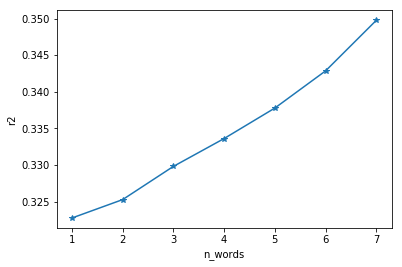

In [106]:
plt.plot(stats.n_words, stats.r2, '-*')
plt.xlabel('n_words')
plt.ylabel('r2')

Wow, that's not half bad! From 3-word windows we can predict about a third of the variance in specificity.

In [107]:
window_models[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_details   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     123.5
Date:                Thu, 11 Oct 2018   Prob (F-statistic):          1.95e-168
Time:                        11:12:36   Log-Likelihood:                -4794.9
No. Observations:                2017   AIC:                             9608.
Df Residuals:                    2008   BIC:                             9658.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 9.0854      0.530     17.156      0.000       8.047      10.124
C(image_id)[T.223777]    -3.7035      0.242    -15.321      0.000      -4.178      -3.229
C(image_id)[T.227326]    -3.0875      0.230    -13.397      0.000      -3.539      -2.636
C(image_id)[T.240275]    -4.5527      0.259    -17.606      0.000      -5.060      -4.046
C(image_id)[T.247576]     0.8376      0.233      3.602      0.000       0.382       1.294
C(image_id)[T.275449]    -1.8379      0.246     -7.477      0.000      -2.320      -1.356
C(image_id)[T.396295]    -2.1283      0.255     -8.351      0.000      -2.628      -1.629
C(image_id)[T.431140]     0.0498      0.234      0.212      0.832      -0.410       0.510
mean_freq                -0.2065      0.087     -2.378      0.017      -0.377      -0.036
==============================================================================
Omnibus:                      133.186   Durbin-Watson:                   0.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.069
Skew:                           0.643   Prob(JB):                     1.06e-35
Kurtosis:                       3.513   Cond. No.                         60.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I'd like to peek at the test set now, or at least CV, but let's first look at the data.

In [108]:
windows = extract_windows(dataset, 3)
model = window_models[3]
windows['predicted'] = model.predict(windows)

In [109]:
windows[windows.image_id == 240275].sort_values('predicted')

,thash,words,image_id,mean_freq,min_freq,num_details,predicted
978,-3047438891064459374,man in a,240275,6.830000,5.84,4,3.122544
972,4435347489334889694,middle of the,240275,6.803333,5.19,2,3.128050
971,4435347489334889694,the middle of,240275,6.803333,5.19,2,3.128050
966,4435347489334889694,top of a,240275,6.776667,5.52,2,3.133556
883,-7712457882236624718,a man is,240275,6.753333,5.84,3,3.138374
970,4435347489334889694,in the middle,240275,6.750000,5.19,2,3.139062
923,6818295234892076186,and a white,240275,6.743333,5.46,5,3.140438
924,6818295234892076186,a white and,240275,6.743333,5.46,5,3.140438
932,4486938847877764030,a white and,240275,6.743333,5.46,4,3.140438
864,3790708998273128546,a white and,240275,6.743333,5.46,3,3.140438


Are there specific words that are commonly used in high and not low?

In [110]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression

In [111]:
def lookup_sorted(arr, labels, n, top=True):
    argsort = np.argsort(arr)
    if top:
        argsort = argsort[::-1]
    return [labels[i] for i in argsort[:n]]

In [122]:
for image_id, group in windows.groupby('image_id'):
    vectorizer = CountVectorizer(binary=True, min_df=10) # min_df should relate with n_words.
    vecs = vectorizer.fit_transform(group.words)
    clf = LinearRegression().fit(vecs, group.num_details)
    voc = vectorizer.get_feature_names()
    print('{}: {}'.format(image_id, text_hashes[group.loc[group.num_details.idxmax()].thash]))
    print(len(voc))
    print(', '.join(lookup_sorted(clf.coef_, voc, 5, top=True)))
    print()

200451: a man in a red shirt with two children are on a beach holding a multi-colored kite while other people fly kites in the background
13
fly, in, man, two, children

223777: some train tracks with a train on it traveling beside some white and blue buildings with green trees in the background and a clear blue sky
16
in, and, with, some, of

227326: a black and white photo of a wedding. the groom and a camerawoman are helping the bride cut the wedding cake on the table filled with glasses and chocolates
21
are, the, black, wedding, with

240275: a male surfer in a white shirt black sleeves and black pants is surfing waves on a white surfboard
13
black, white, is, and, man

247576: a city view of a busy london street filled with a black car and a red double decker bus driving on the street. many people fill the sidewalk mostly the right side
19
driving, car, busy, to, people

275449: a yellow cat with stripes is sitting on a place mat on a table behind a half of glass of red wine
19
h

Well the word-classifier idea is noisy on windows, but how about full strings?

In [139]:
from sklearn.linear_model import Ridge

Use Ridge regression to control overfitting to the occurrence of a single word, since this is so sparse. (Not Lasso, since we don't want zeros.) I tried alpha=10 and it seemed to be reasonable because the R^2's went from 0.95's to 0.5's, suggesting much less overfitting. Would be nice to CV this, but we'd want to learn a vocab from the entire set.

In [145]:
print("Words predicting specificity (Ridge Regression)")
print()
for image_id, group in dataset.groupby('image_id'):
    vectorizer = CountVectorizer(binary=True, min_df=2, stop_words='english')
    vecs = vectorizer.fit_transform(group.text)
    clf = Ridge(alpha=10.).fit(vecs, group.num_details)
    coef = clf.coef_
    voc = vectorizer.get_feature_names()
    print('img={}: {}...'.format(image_id, group.loc[group.num_details.idxmax()].text[:50]))
    print('r2={:.3f}'.format(r2_score(group.num_details, clf.predict(vecs))))
    print('best word(weight): ' + ', '.join(
        '{}({:.2f})'.format(voc[idx], coef[idx]) for idx in np.argsort(coef)[::-1][:5]))
    print('worst word(weight): ' + ', '.join(
        '{}({:.2f})'.format(voc[idx], coef[idx]) for idx in np.argsort(coef)[::1][:5]))
    print()

Words predicting specificity (Ridge Regression)

img=200451: a man in a red shirt with two children are on a be...
r2=0.559
best word(weight): man(0.74), children(0.61), beach(0.41), butterfly(0.37), sandy(0.36)
worst word(weight): sky(-0.55), kites(-0.52), kids(-0.23), stand(-0.22), family(-0.11)

img=223777: some train tracks with a train on it traveling bes...
r2=0.585
best word(weight): blue(0.68), white(0.65), buildings(0.57), trees(0.35), colored(0.24)
worst word(weight): road(-0.30), rail(-0.30), station(-0.25), train(-0.15), passes(-0.04)

img=227326: a black and white photo of a wedding. the groom an...
r2=0.388
best word(weight): table(0.38), bride(0.33), helping(0.30), black(0.27), groom(0.27)
worst word(weight): wedding(-0.36), man(-0.12), woman(-0.09), couple(-0.05), photographer(-0.03)

img=240275: a male surfer in a white shirt black sleeves and b...
r2=0.596
best word(weight): white(0.51), pants(0.41), shirt(0.41), black(0.37), blonde(0.35)
worst word(weight): ocean(-0.

- 200451 (kites): makes no sense.
- 223777 (train): nice (blue, white, buildings, trees all good; train and station are boring.
- 227326 (wedding posing): table, helping, black are good, why is photographer negative? why are bride and groom positive? don't all have them?
- 240275 (surfing): white, pants, shirt, blonde...great. ocean, riding, surfer, wave boring. Nice!
- 247576 (London street): sidewalks, people, black car: great. city, street boring. But why is 'walking' negative?

TODO Finish

Maybe... do we have some outliers with really low specificity that we do well to just avoid?

In [104]:
text_hashes = {}
for text in dataset.text:
    h = hash(text)
    assert h not in text_hashes
    text_hashes[h] = text

# Residuals

In [86]:
model = models['C(image_id) + num_words + total_rarity']

In [102]:
model.params

Intercept                2.028836
C(image_id)[T.223777]   -3.921374
C(image_id)[T.227326]   -4.010874
C(image_id)[T.240275]   -3.669458
C(image_id)[T.247576]   -0.441358
C(image_id)[T.275449]   -1.857812
C(image_id)[T.396295]   -1.882714
C(image_id)[T.431140]   -1.300798
num_words                0.148274
total_rarity             1.198227
dtype: float64

In [87]:
predicted = model.predict(dataset)

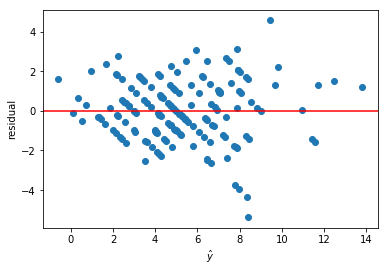

In [88]:
plt.scatter(predicted, model.resid)
plt.axhline(0, color='r')
plt.xlabel('$\hat{y}$')
plt.ylabel('residual');

Ok, let's have a look at captions for which length and frequency don't predict num_details well.

In [89]:
dsr = dataset.copy()

In [90]:
dsr['resid'] = model.resid
dsr['resid_mag'] = model.resid.abs()
dsr['predicted'] = predicted
dsr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 15 columns):
image_id                168 non-null int64
text                    168 non-null object
num_details             168 non-null int64
num_words               168 non-null int64
min_freq                168 non-null float64
mean_freq               168 non-null float64
num_tokens              168 non-null int64
mean_logprob_uncond     168 non-null float64
total_logprob_uncond    168 non-null float64
mean_rarity             168 non-null float64
max_rarity              168 non-null float64
total_rarity            168 non-null float64
resid                   168 non-null float64
resid_mag               168 non-null float64
predicted               168 non-null float64
dtypes: float64(10), int64(4), object(1)
memory usage: 19.8+ KB


In [91]:
pd.set_option('display.max_colwidth', 150)

In [92]:
print("over-predicted:")
dsr[dsr.predicted.between(4,8)]['image_id text num_tokens resid predicted total_logprob_uncond num_details'.split()].sort_values('resid').iloc[:5]

over-predicted:


,image_id,text,num_tokens,resid,predicted,total_logprob_uncond,num_details
3,200451,several multicolored kites with streamers are seen soaring above the heads of people,13,-3.951625,7.951625,54.609120,4
22,223777,"the image shows a railroad track with a train on it further out in the distance. multiple white buildings hug the side if the track, with some woo...",31,-3.762824,7.762824,180.252899,4
9,200451,one kite flying over four other kites on a blue sky,11,-2.631449,6.631449,43.533666,4
103,247576,a double decker bus traveling down the middle of the street in the city streets,15,-2.478494,6.478494,36.642353,4
164,431140,toilet paper roll is on top of the toilet in a mellow yellow painted bathroom,15,-2.450966,6.450966,75.009583,4


In [93]:
print("Under-predicted")
dsr[dsr.predicted.between(4,8)]['image_id text num_tokens resid predicted total_logprob_uncond num_details'.split()].sort_values('resid').iloc[-5:]

Under-predicted


,image_id,text,num_tokens,resid,predicted,total_logprob_uncond,num_details
145,396295,a tan towel is hanging from a chrome handle on a textured glass shower door,15,2.521566,6.478434,81.209793,9
120,275449,a half full glass of red wine on a table in front of a calico cat,16,2.541482,5.458518,38.410653,8
2,200451,a man and his two children are flying multicolored kites on a sandy beach,14,2.660120,7.339880,39.750552,10
7,200451,a man flies a butterfly kite with his two daughters,10,3.076568,5.923432,37.889245,9
151,431140,a bathroom with a white sink and white toilet. a roll of unwrapped toilet paper sits on the bowl,19,3.115469,7.884531,97.487974,11


I notice: 

- We can generally do surprisingly well on this task using total rarity. We can explain about 74% of the variance in details.
- Some of the over-predicts actually have more details than I gave them credit for. Some of the under-predicts are less detailed.
- Some of the over-predicted just have extra words ("there is" one kite; "a view of" a bathroom, "in the city streets"); I went back and stripped them off and the above reflects that. (we get a boost of about 0.01 R^2.)

Since this model has image only as a slope (should be random but alas I'm lazy), we can still get relative details measures.

# Aside: random-effects model.

In [94]:
md = smf.mixedlm("num_details ~ mean_rarity + num_tokens + total_rarity", dataset, groups=dataset["image_id"])

md.fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: num_details
No. Observations: 168     Method:             REML       
No. Groups:       8       Scale:              2.4408     
Min. group size:  21      Likelihood:         -323.9069  
Max. group size:  21      Converged:          Yes        
Mean group size:  21.0                                   
---------------------------------------------------------
              Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------
Intercept      0.371    1.431  0.259 0.795  -2.434  3.177
mean_rarity   -2.535    6.720 -0.377 0.706 -15.707 10.636
num_tokens     0.118    0.085  1.392 0.164  -0.048  0.285
total_rarity   1.360    0.465  2.924 0.003   0.449  2.272
groups RE      2.372    0.870                            
=========================================================

"""

In [95]:
md = smf.mixedlm("num_details ~ total_rarity", dataset, groups=dataset["image_id"])
mdf = md.fit()
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: num_details
No. Observations: 168     Method:             REML       
No. Groups:       8       Scale:              2.6164     
Min. group size:  21      Likelihood:         -330.8710  
Max. group size:  21      Converged:          Yes        
Mean group size:  21.0                                   
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.251    0.641  0.392 0.695 -1.006  1.508
total_rarity    1.911    0.126 15.161 0.000  1.664  2.158
groups RE       2.295    0.817                           
=========================================================

"""

In [96]:
r2_score(dataset['num_details'], mdf.predict(dataset))

0.4685851105546911

I don't understand why that R^2 score is much smaller than the fixed-effects version. Probably we have different parameters.

In [97]:
model.params

Intercept                2.028836
C(image_id)[T.223777]   -3.921374
C(image_id)[T.227326]   -4.010874
C(image_id)[T.240275]   -3.669458
C(image_id)[T.247576]   -0.441358
C(image_id)[T.275449]   -1.857812
C(image_id)[T.396295]   -1.882714
C(image_id)[T.431140]   -1.300798
num_words                0.148274
total_rarity             1.198227
dtype: float64

In [98]:
mdf.params

Intercept       0.251184
total_rarity    1.910701
groups RE       0.877341
dtype: float64

In [99]:
re_params = pd.Series({k: v.iloc[0] for k, v in mdf.random_effects.items()})
re_params

200451    1.872634
223777   -1.622234
227326   -1.584410
240275   -1.634757
247576    1.683106
275449    0.232425
396295    0.041020
431140    1.012215
dtype: float64

In [100]:
fixed_params = pd.Series({int(k[14:-1]): v for k, v in model.params.items() if k.startswith('C')})
fixed_params

223777   -3.921374
227326   -4.010874
240275   -3.669458
247576   -0.441358
275449   -1.857812
396295   -1.882714
431140   -1.300798
dtype: float64

In [101]:
d = pd.DataFrame(dict(fixed=fixed_params + model.params['Intercept'], random=re_params + mdf.params['Intercept']))
d['diff'] = d['fixed'] - d['random']
d['absdiff'] = d['fixed'].abs() - d['random'].abs()
d.mean(axis=0)

fixed     -0.411791
random     0.251184
diff      -0.395455
absdiff    0.012358
dtype: float64

The random-effects estimates are generally smaller.